# Implementing Grover's Algorithm

The problem: Boolean Satisfiability

"SAT problems" are a class of problems that deal with Boolean expressions.
A SAT problem is defined by a set of Boolean expressions, and the "solutions" are the strings of bits that satisfy all of the constraints.
3-SAT is a subclass of SAT problems with 3 bits, and that's where we'll start.

In [ ]:
# Some helper functions

def getBitstrings(n):
    if n == 1:
        return ["0", "1"]
    else:
        return ["0"+substr for substr in getBitstrings(n-1)] + ["1"+substr for substr in getBitstrings(n-1)]


In [ ]:
# Creating a 3-SAT problem statement in DIMACS file format

solutions = ["111", "101", "110"]
clauses = []

for bitstr in getBitstrings(3):
    if bitstr not in solutions:
        bitstr = bitstr[::-1]
        clause = ""
        for i, bit in enumerate(bitstr):
            clause += f"{i+1} " if bit == "0" else f"-{i+1} "
        clauses.append(clause + "0")

clauses

In [ ]:
# Writing the clauses to a file

with open("/Users/rohanmalik/Desktop/RCDS 2021-22/_Quantum Computing IS/QiskitProjects/test.dimacs", mode='w', encoding='utf8') as satFile:
    satFile.write(f"p cnf 3 {len(clauses)}\n")
    satFile.writelines(clauses)

In [ ]:
# Creating an "oracle" circuit from the constraints in the file

from qiskit.circuit.library import PhaseOracle

oracle = PhaseOracle.from_dimacs_file("/Users/rohanmalik/Desktop/RCDS 2021-22/_Quantum Computing IS/QiskitProjects/test.dimacs")
oracle.draw(output="mpl");

The "oracle" circuit will flip the phase (i.e. apply a Z gate) of any state that corresponds to a solution, and leave the other states alone.
Now with this circuit in place, the next piece we need is a so-called "diffuser" or "amplifier", that tweaks the probabilities of the states such that the phase-shifted ones become more likely to measure.
Grover's algorithm involves running the oracle and diffuser multiple times to slowly increase the chances of measuring solution states more and more, up to arbitrary precision.

The intuition for the algorithm relies in statevectors — let's create a new coordinate system whose basis vectors are the superposition of all wrong states |X> and the superposition of all solution states |√>.
We start in a superposition of all possible states |s>, which will likely lie closer to X than to √ since there are only a few solutions.
We want to try to manipulate s to get it as close to √ as possible so we can measure and have a high chance of getting a solution.
Our "oracle" flips all solution states, so it effectively reflects the statevector over the X axis.
So if we then have a way to reflect the statevector over |s>, we will end up closer to the √ axis! This is the role of the "diffuser" circuit.

In [ ]:
# Creating a "diffuser" circuit that amplifies solution states

from qiskit import QuantumCircuit

diff = QuantumCircuit(3)
allQubits = list(range(3))
diff.h(allQubits)
diff.x(allQubits)
diff.barrier()
diff.h(2)
diff.mct(allQubits[:-1], 2)
diff.h(2)
diff.barrier()
diff.x(allQubits)
diff.h(allQubits)
diff.draw(output="mpl");


In [ ]:
def diffuser(n):
    qc = QuantumCircuit(n)
    allQubits = list(range(n))
    qc.h(allQubits)
    qc.x(allQubits)
    qc.h(n-1)
    qc.mct(allQubits[:-1], n-1)
    qc.h(n-1)
    qc.x(allQubits)
    qc.h(allQubits)
    diffuserGate = qc.to_gate()
    diffuserGate.name = "diff"
    return diffuserGate

How do we reflect around |s>? Well, we know that the controlled Z gate can reflect around |11> (since it flips the phase of that state).
So if we transform |s> to |11>, reflect around it, then reverse the transformation, we achieve the desired result.
We can take |s> to |00> by applying the H gate (since an H gate on a superposition takes the qubits back to their basis state).
Then we apply X gates to change |00> to |11>, and we have the transformation |s> -> |11>.
Next, we apply a controlled-Z gate to all the qubits ("multi-controlled" so it can generalize to any number of qubits in the state |111...1>)
We have to apply H gates and a multi-controlled X gate instead (since a pure MCZ doesn't exist), but they are equivalent since the H gate switches between the X and Z basis then switches back.
Then we simply reverse the transformation to go from |11> -> |s> and the diffuser is complete.

In [ ]:
# Creating the Grover's Algorithm Circuit

grover = QuantumCircuit(3)
grover.h([0, 1, 2])  # initialize the |s> state, an equal superposition
grover.barrier()
grover = grover.compose(oracle)  # add the oracle
grover.append(diffuser(3), [0, 1, 2])  # add the diffuser
grover.measure_all()
grover.draw(output="mpl");


In [ ]:
# Simulating the circuit and interpreting results

from qiskit import Aer, transpile, assemble
from qiskit.visualization import plot_histogram
sim = Aer.get_backend('aer_simulator')
transpiled = transpile(grover, sim)
assembled = assemble(transpiled)
plot_histogram(sim.run(assembled).result().get_counts());


In [ ]:
# If we run some more iterations...

grover = QuantumCircuit(3)
grover.h([0, 1, 2])  # initialize the |s> state, an equal superposition
grover.barrier()
grover = grover.compose(oracle)  # add the oracle
grover.append(diffuser(3), [0, 1, 2])  # add the diffuser
grover.barrier()
grover = grover.compose(oracle)
grover.append(diffuser(3), [0, 1, 2])
grover.barrier()
grover = grover.compose(oracle)
grover.append(diffuser(3), [0, 1, 2])
grover.measure_all()
grover.draw(output="mpl");

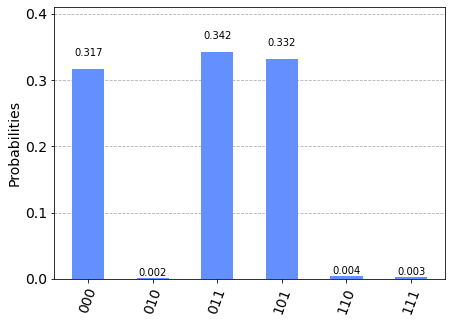

In [40]:
# And simulate it now...

transpiled = transpile(grover, sim)
assembled = assemble(transpiled)
plot_histogram(sim.run(assembled).result().get_counts());

# The confidence is much higher!

In general, we will have to perform the oracle around O(√n) times to get the correct answer.
If the initial angle between |s> and the horizontal is θ, each iteration rotates the vector by 2θ towards the vertical.
sin(θ) = vertical component over vector length; each solution state has magnitude 1/√N because the superposition must be normalized, and the vector length is 1.
So for 1 solution, the sin(θ) is (1/√N) / 1 = 1/√N. By the small angle approximation (which gets more accurate as there are fewer solutions and larger search spaces), θ ≈ 1/√N.
Therefore, the number of iterations it takes to rotate all the way to the vertical is proportional to √N, and so the algorithm is O(√N), a quadratic improvement over classical unstructured search!
